## Parameter Estimation Tutorial

In [1]:
import site
site.addsitedir('/home/b3053674/Documents/pycotools')
import os, glob
from pycotools import model, tasks, viz, misc
%matplotlib inline

/home/b3053674/Documents/pycotools/pycotools/viz.py:117: FutureWarning: The pandas.parser module is deprecated and will be removed in a future version. Please import from the pandas.io.parser instead
  from pandas.parser import CParserError
/home/b3053674/anaconda2/envs/pycotools/lib/python2.7/site-packages/tellurium/tellurium.py:40: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/b3053674/anaconda2/envs/pycotools/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/b3053674/anaconda2/envs/pycotools/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/b3053674/anaconda2/envs/pycotools/lib/python2.7/site

### Build a Model

In [2]:
working_directory = '/home/b3053674/Documents/Models/2018/03_March/ParameterEstimationDemo'

copasi_file = os.path.join(working_directory, 'negative_feedback.cps')

with model.BuildAntimony(copasi_file) as loader:
    mod = loader.load(
        """
        model negative_feedback
            compartment cell = 1.0
            var A in cell
            var B in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            A = 0
            B = 0

            AProd: => A; cell*vAProd
            ADeg: A =>; cell*kADeg*A*B
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
        end
        """
    )

## open model in copasi
mod.open()

### Experimental Data Files
Any experimental data files are passed to COPASI and should comply with [COPASI's format](http://copasi.org/Support/User_Manual/Tasks/Parameter_Estimation/). In addition, here are some additional rules to follow for using PyCoTools with COPASI:

    - Column headings must match model variables exactly in order to be mapped. 
    - Independant variables can be mapped by appending the suffix `_indep` to the variable.
        - For example, if you vary the concentration of A between 0 and 10ng/mL in an experiment:
        
                Time A_indep  B   C
                t=1   0       -   - 
                t=2   0           -
                t=3  10           -
                t=4  10       -   -
    - Do not use non-asci strings (i.e. alpha or beta) in parameter definitions. They are minimally supported in pycotools but this is unstable. 

Copasi time course output contains additional content in headers (i.e. `Values[specie_x]` instead of just `species_x`). For this demonstration to work the column headers must exactly match model variables. The `misc.format_timecourse_data` function specifically deals with this issue for the sake of this example.  `misc.format_timecourse_data` operates inplace (i.e. changes the content of the file) and returns the data as a `pandas.DataFrame`. 

### Simulate Experimental Data

In [3]:
## choose report name
report= 'parameter_estimation_synthetic_data.txt'

## simulate some data. Set global variables to empty list to remove them from the data file output
TC=tasks.TimeCourse(mod, start=0, end=10, intervals=10, step_size=1, report_name=report, 
                   global_quantities=[])

## assign simulated data file to variable
exp_data = TC.report_name

print(os.path.isfile(exp_data))

True


### Format the Simulated Data

In [4]:
misc.format_timecourse_data(exp_data)

,Time,B,A
0,0,0.000000,0.000000
1,1,0.013181,0.099932
2,2,0.046643,0.199023
3,3,0.093275,0.295526
4,4,0.147810,0.387233
5,5,0.206160,0.471935
6,6,0.265083,0.547789
7,7,0.322023,0.613554
8,8,0.375056,0.668702
9,9,0.422852,0.713393


### Setup and run single parameter estimation 

Method outline:

    1) Instantiate ParameterEstimation instance with model and data filenames
        - Ensure optional arguments are specified to the ParameterEstimation class
    2) Use `write_config_template()` method to write and configure a parameter estimation config file.
    2) Use `setup()` method
    3) Use `run()` method
    4) Use `format_results()` method (to give output results meaningful headers)

In [5]:
PE=tasks.ParameterEstimation(mod, exp_data, method='hooke_jeeves', tolerance=1e-6, iteration_limit=1000)

#### Use Particle Swarm

In [6]:
PE=tasks.ParameterEstimation(mod, exp_data, method='particle_swarm', swarm_size=50)

### Use Genetic Algorithm

In [7]:
## Set getetic algorithm parameters to low for speed of demonstration
PE=tasks.ParameterEstimation(mod, exp_data, method='genetic_algorithm', 
                             population_size=15, number_of_generations=10)

### Write Parameter Estimation Configuration File

In [8]:
PE.write_config_file()
os.path.isfile(PE.config_filename)

True

### Configure Parameter Estimation
Parameter Estimations can be configured manually or programmatically.

##### Configure with API
The `metabolites`, `global_parameters` and `local_parameters` atributes of the `tasks.parameter_estimation` class tell Pycotools which parameters to include in the config file. By default all model parameters are included but these can be overridden by giving our own lists. We can set these to empty lists to specify that we do not want to include them in the estimation process. We can also use the `upper_bound` and `lower_bound` arguments to constrain the estimation problem.


##### Configure manually
Configuration files can also be configured manually. This is useful for when an optimization problem requires a more complex setup - maybe different estimated parameters need different boundaries. To configure manually: 

    - Delete rows with parameters you do not want estimated
    - Change start values, lower bounds and upper bounds
        - To set custom start values, remember to set the "randomize_start_values" to False.
    - If configuring manually, it is a good idea to set the "overwrite_config_file" argument to False.

In [9]:
PE = tasks.ParameterEstimation(
    mod, exp_data, 
    method='genetic_algorithm', population_size=30, number_of_generations=100,
    lower_bound = 0.001, upper_bound = 3000)

### Set up the Parameter Estimation

In [10]:
PE.setup()

Model(name=negative_feedback, time_unit=s, volume_unit=l, quantity_unit=mol)

### Run Parameter Estimation

In [11]:
PE.run()

#### Check Parameter Estimation Report Exists

In [12]:
os.path.isfile(PE.report_name)

True

### Visualize Parameter Estimaton Data

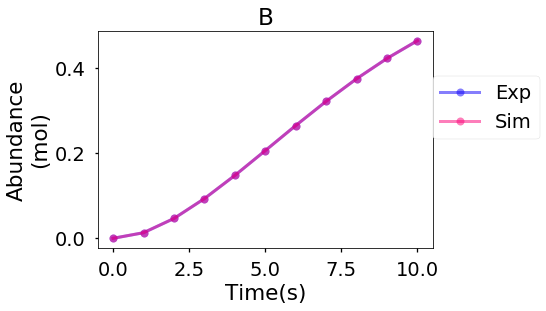

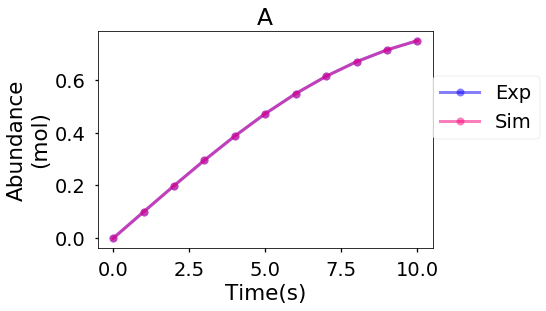

In [13]:
viz.PlotParameterEstimation(PE)

#### Save to File

pycotools.viz:INFO:1843:    figure saved to "/home/b3053674/Documents/Models/2018/03_March/ParameterEstimationDemo/ParameterEstimationPlots/parameter_estimation_synthetic_data/B.png"
pycotools.viz:INFO:1843:    figure saved to "/home/b3053674/Documents/Models/2018/03_March/ParameterEstimationDemo/ParameterEstimationPlots/parameter_estimation_synthetic_data/A.png"


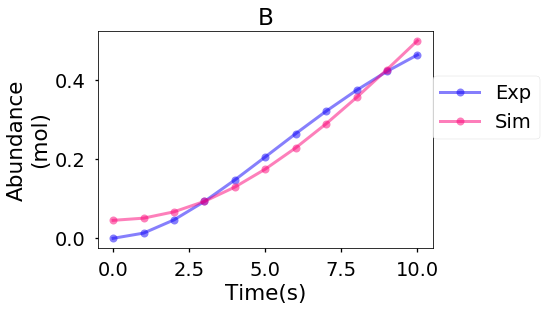

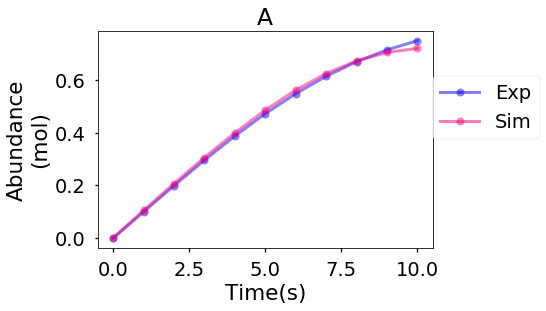

In [14]:
viz.PlotParameterEstimation(PE, savefig=True)

#### Choose Results Directory

pycotools.viz:INFO:1843:    figure saved to "/home/b3053674/Documents/Models/2018/03_March/ParameterEstimationDemo/ParameterEstimationDemoResults/parameter_estimation_synthetic_data/B.png"
pycotools.viz:INFO:1843:    figure saved to "/home/b3053674/Documents/Models/2018/03_March/ParameterEstimationDemo/ParameterEstimationDemoResults/parameter_estimation_synthetic_data/A.png"


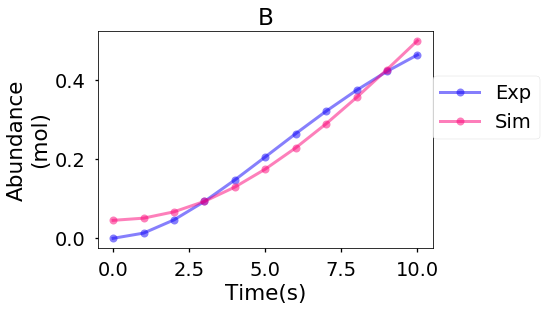

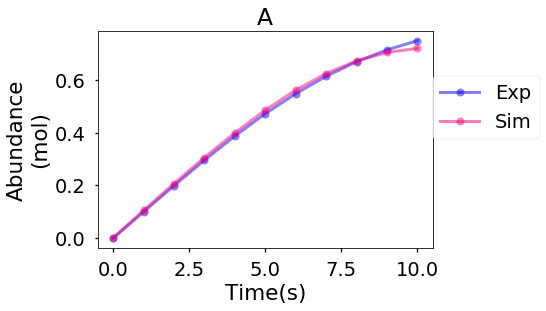

In [15]:
results_dir = os.path.join(working_directory, 'ParameterEstimationDemoResults')
viz.PlotParameterEstimation(PE, savefig=True, results_directory=results_dir)

#### Specify Which Variables to Plot

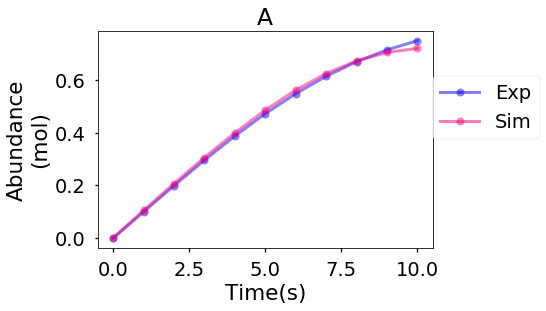

In [16]:
viz.PlotParameterEstimation(PE, y=['A'])

### Multiple Data Files

Pycotools handles multiple data files by giving `ParameterEsimation` a list of data file paths as its second argument. For demonstration we change the value of a parameter and simulate some more data

Lets simulate some more data.

Lets first change a model parameter so both sets of simulated data are not identical:

In [17]:
working_directory = '/home/b3053674/Documents/Models/2018/03_March/ParameterEstimationDemo'

copasi_file2 = os.path.join(working_directory, 'negative_feedback_with_signal.cps')

with model.BuildAntimony(copasi_file2) as loader:
    mod2 = loader.load(
        """
        model negative_feedback
            compartment cell = 1.0
            var A in cell
            var B in cell
            var Signal in cell

            vAProd = 0.1
            kADeg = 0.2
            kBProd = 0.3
            kBDeg = 0.4
            A = 0
            B = 0
            Signal = 10

            AProd: $Signal => A; cell*vAProd*Signal
            ADeg: A =>; cell*kADeg*A*B
            BProd: => B; cell*kBProd*A
            BDeg: B => ; cell*kBDeg*B
        end
        """
    )

## open model in copasi
mod2.open()

#### Generate Multiple Synthetic Data Files

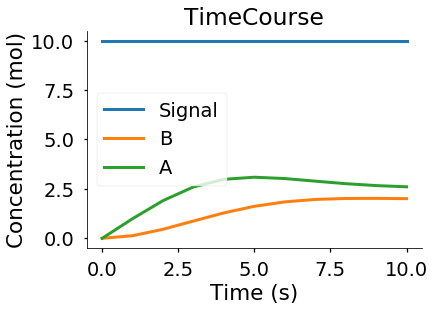

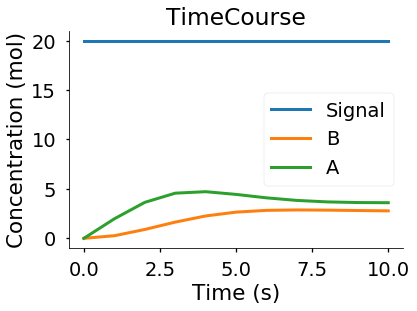

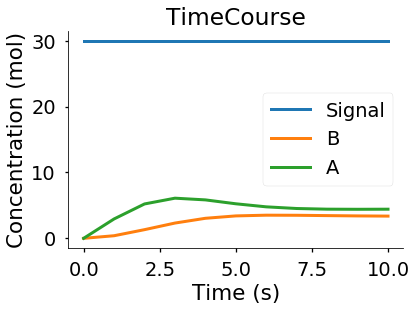

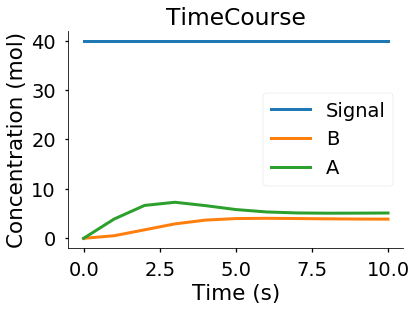

In [18]:
import pandas
## initialize empty dict to store TimeCourse objects
TC_dict = {}
for i in [10, 20, 30, 40]:
    ## modify signal parameter
    model.InsertParameters(mod2, parameter_dict={'Signal': i}, inplace=True)
    
    ## create unique report name
    report_name = os.path.join(working_directory, 'timecourse_signal_{}.txt'.format(i))
    
    ## simulate time course. Turn off recording global quantities
    TC_dict[i] = tasks.TimeCourse(mod2, end=10, intervals=10, step_size=1, report_name=report_name, 
                            global_quantities=[])
    viz.PlotTimeCourse(TC_dict[i], separate=False)
    
    
    ## format the time course data
    df = misc.format_timecourse_data(TC_dict[i].report_name)
    
    ## create independent variable column
    df['Signal_indep'] = [i]*df.shape[0]
    
    ## write data to file
    df.to_csv(TC_dict[i].report_name, sep='\t', index=False)

#### Setup and Run Parameter Estimation

In [19]:
PE2 = tasks.ParameterEstimation(mod2, [i.report_name for i in TC_dict.values()], 
                                method='genetic_algorithm', population_size=30, 
                                number_of_generations=100, run_mode=True
                               )

PE2.write_config_file()
PE2.setup()
# PE2.model.open() ## to check the model
PE2.run()

#### Plot the Results

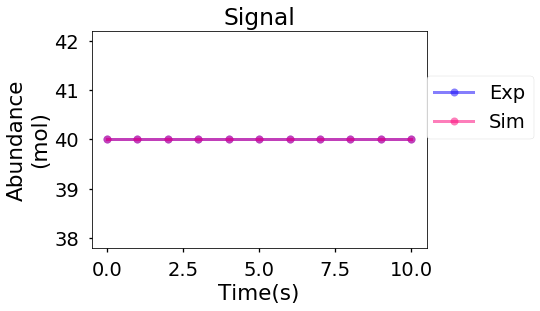

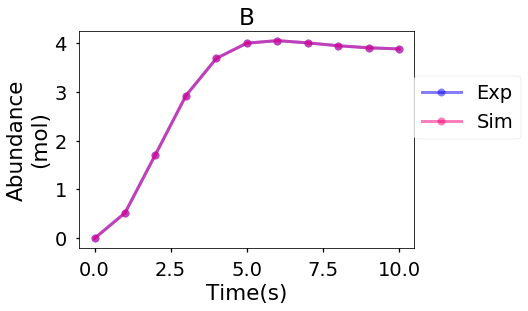

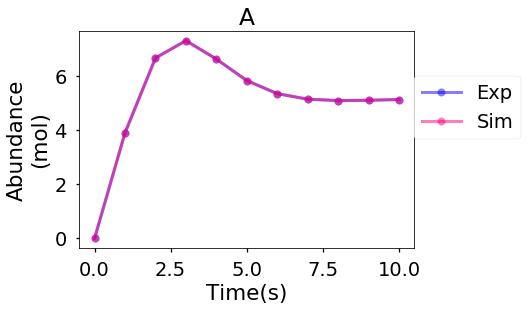

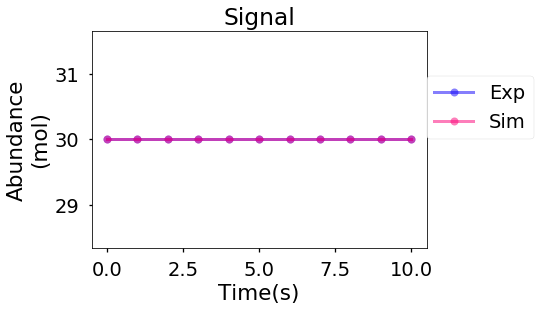

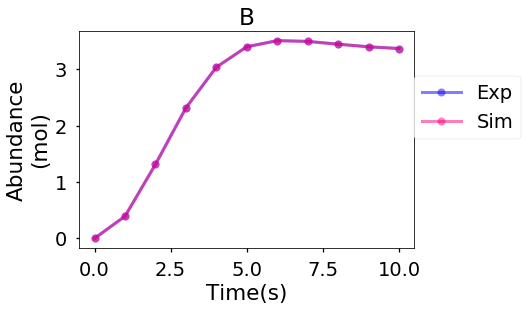

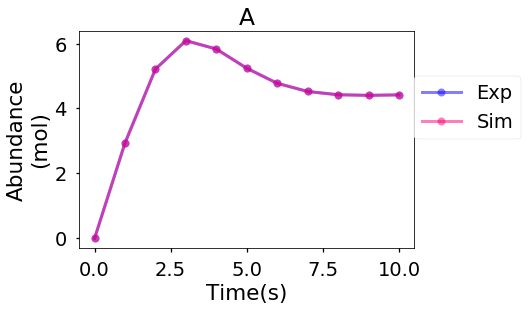

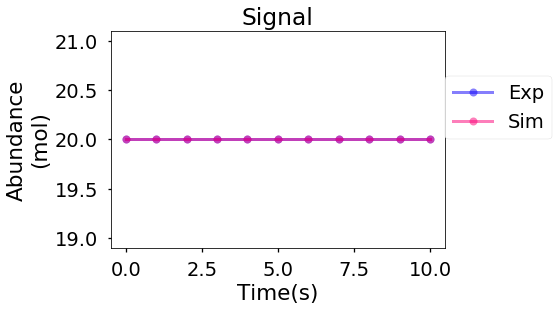

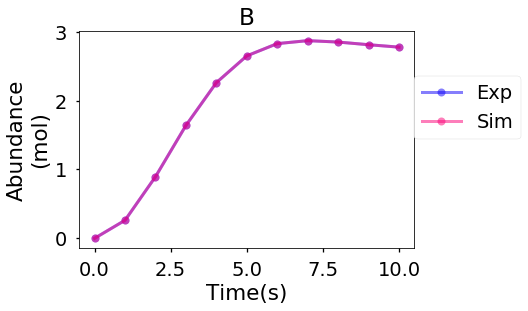

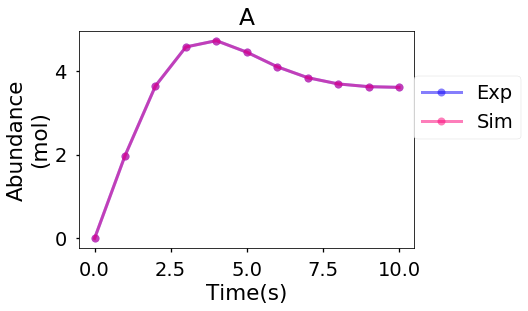

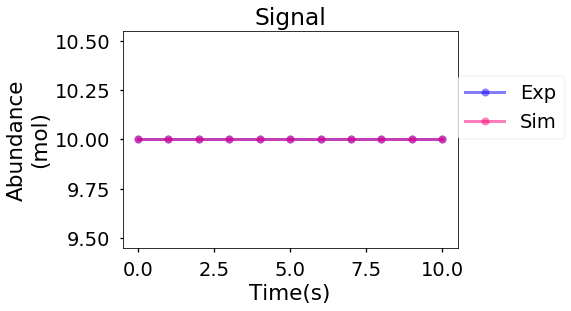

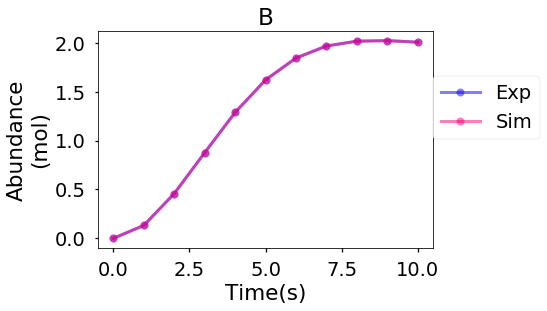

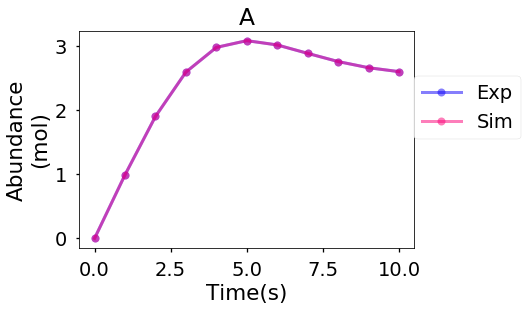

In [20]:
viz.PlotParameterEstimation(PE2)

### Steady State Experiments
By default, all data files are timecourse. To specify timecourse data we need to add a few more arguments to the ParameterEstimation instantiation - namely the experiment type argument. 

##### Create Synthetic Steady State Data

In [21]:
steady_state_data_file = os.path.join(working_directory, 'steady_state_data.txt')
df = pandas.DataFrame([400], columns=['A'])
print(df)
df.to_csv(steady_state_data_file, index=False)

     A
0  400


#### Setup and Run Parameter Estimation

In [22]:
config_file = os.path.join(working_directory, 'steadystate_config_file.csv')
PE3 = tasks.ParameterEstimation(
    mod, [TC.report_name, steady_state_data_file],
    experiment_type=['timecourse', 'steadystate'],
    weight_method=['mean_squared', 'mean_squared'],
    method='genetic_algorithm', population_size=15,
    number_of_generations=10, metabolites=[], local_parameters=[],
    lower_bound = 0.001, upper_bound = 3000, config_filename = config_file
)
PE3.write_config_file()
PE3.setup()
PE3.run()